In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------
# Data Loading and Preparation
# -------------------------------
file_path = r'C:\Users\Χρήστος\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Define target columns and category grouping
target_columns = [
    "SA_1_understanding_job_roles",
    "SA_2_understanding_job_roles",
    "SA_3_understanding_job_roles",
    "SA_4_understanding_job_roles",
    "SA_5_understanding_job_roles",
    "SA_6_teamwork_in_emergencies",
    "SA_7_teamwork_in_emergencies",
    "SA_8_teamwork_in_emergencies",
    "SA_9_teamwork_in_emergencies",
    "SA_10_teamwork_in_emergencies",
    "SA_11_teamwork_and_communication",
    "SA_12_teamwork_and_communication",
    "SA_13_teamwork_and_communication",
    "SA_14_teamwork_and_communication",
    "SA_15_teamwork_and_communication",
    "SA_16R_teamwork_and_communication",
    "SA_17_teamwork_and_communication",
    "SA_18_teamwork_and_communication",
    "SA_19_teamwork_and_communication",
    "SA_20_teamwork_and_communication",
    "SA_21_teamwork_and_communication",
    "SA_22R_teamwork_and_communication",
    "SA_23_teamwork_and_communication",
    "SA_24_teamwork_and_communication",
    "SA_25_teamwork_and_communication",
    "SA_26_clear_communication_within_team",
    "SA_27_clear_communication_within_team",
    "SA_28_clear_communication_within_team",
    "SA_29_clear_communication_within_team",
    "SA_30_clear_communication_within_team",
    "SA_31_clear_communication_within_team",
    "SA_32_clear_communication_within_team",
    "SA_33_clear_communication_within_team",
    "SA_34R_clear_communication_within_team"
]

categories = {
    "Understanding of job roles": [
        "SA_1_understanding_job_roles",
        "SA_2_understanding_job_roles",
        "SA_3_understanding_job_roles",
        "SA_4_understanding_job_roles",
        "SA_5_understanding_job_roles"
    ],
    "Teamwork in emergencies": [
        "SA_6_teamwork_in_emergencies",
        "SA_7_teamwork_in_emergencies",
        "SA_8_teamwork_in_emergencies",
        "SA_9_teamwork_in_emergencies",
        "SA_10_teamwork_in_emergencies"
    ],
    "Overall importance of effective teamwork and communication": [
        "SA_11_teamwork_and_communication",
        "SA_12_teamwork_and_communication",
        "SA_13_teamwork_and_communication",
        "SA_14_teamwork_and_communication",
        "SA_15_teamwork_and_communication",
        "SA_16R_teamwork_and_communication",
        "SA_17_teamwork_and_communication",
        "SA_18_teamwork_and_communication",
        "SA_19_teamwork_and_communication",
        "SA_20_teamwork_and_communication",
        "SA_21_teamwork_and_communication",
        "SA_22R_teamwork_and_communication",
        "SA_23_teamwork_and_communication",
        "SA_24_teamwork_and_communication",
        "SA_25_teamwork_and_communication"
    ],
    "Importance of clear communication within the maintenance team": [
        "SA_26_clear_communication_within_team",
        "SA_27_clear_communication_within_team",
        "SA_28_clear_communication_within_team",
        "SA_29_clear_communication_within_team",
        "SA_30_clear_communication_within_team",
        "SA_31_clear_communication_within_team",
        "SA_32_clear_communication_within_team",
        "SA_33_clear_communication_within_team",
        "SA_34R_clear_communication_within_team"
    ]
}

# Separate input features and targets
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# --------------------------------------------
# Function: Feature Importance using AdaBoost
# --------------------------------------------
def get_important_features_adaboost(input_features, targets, num_features):
    feature_importances = {}
    # Compute importance for each target individually
    for target in targets.columns:
        # Create a temporary train/test split for stability
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
            X_scaled, targets[target], test_size=0.2, random_state=42
        )
        # Set algorithm="SAMME" to avoid the deprecation warning
        ab = AdaBoostClassifier(n_estimators=500, random_state=42, algorithm="SAMME")
        ab.fit(X_train_tmp, y_train_tmp)
        feature_importances[target] = ab.feature_importances_
    
    # Average importance across all targets
    mean_importance = pd.DataFrame(feature_importances).mean(axis=1)
    important_features = pd.DataFrame({
        'Feature': input_features.columns,
        'Importance': mean_importance
    }).sort_values(by='Importance', ascending=False)
    
    selected_features = important_features.head(num_features)['Feature'].tolist()
    return selected_features

# ------------------------------------------------
# Function: Evaluate Model for a Given Feature Count
# ------------------------------------------------
def evaluate_features(num_features):
    # Select features based on AdaBoost importance
    selected_features = get_important_features_adaboost(input_features, targets, num_features)
    X_selected = pd.DataFrame(X_scaled, columns=input_features.columns)[selected_features]
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, targets, test_size=0.2, random_state=42)
    
    # Set algorithm="SAMME" here as well
    ab_model = AdaBoostClassifier(n_estimators=200, random_state=42, algorithm="SAMME")
    multi_target_model_ab = MultiOutputClassifier(ab_model)
    multi_target_model_ab.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = multi_target_model_ab.predict(X_test)
    
    # Compute the average weighted F1-score over all target columns
    f1_scores = []
    for col in targets.columns:
        score = f1_score(y_test[col], y_pred[:, targets.columns.get_loc(col)], average='weighted', zero_division=0)
        f1_scores.append(score)
    
    overall_f1 = np.mean(f1_scores)
    return overall_f1

# ---------------------------------------------------------
# Loop Over a Range of Feature Counts to Find the Best Value
# ---------------------------------------------------------
best_num = None
best_f1 = -1
best_features = None

# Define a range for the number of features to try.
# (For example, from 10 up to the total number of input features, in steps of 10.)
feature_range = range(10, input_features.shape[1] + 1, 10)
results = {}

for num in feature_range:
    print(f"Evaluating model with {num} features...")
    current_f1 = evaluate_features(num)
    results[num] = current_f1
    print(f"  Average weighted F1 Score: {current_f1:.4f}")
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_num = num
        best_features = get_important_features_adaboost(input_features, targets, num)

print("\nOptimization complete.")
print(f"Best number of features: {best_num}")
print(f"Best Average weighted F1 Score: {best_f1:.4f}")
print("Selected Features:", best_features)

# ---------------------------------------------------------
# Final Model Training with the Optimal Number of Features
# ---------------------------------------------------------
print("\nTraining final model using the best number of features...")

# Prepare the dataset using the optimal feature set
X_selected_final = pd.DataFrame(X_scaled, columns=input_features.columns)[best_features]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_selected_final, targets, test_size=0.2, random_state=42
)

# Set algorithm="SAMME" for the final model as well
ab_final = AdaBoostClassifier(n_estimators=200, random_state=42, algorithm="SAMME")
multi_target_final = MultiOutputClassifier(ab_final)
multi_target_final.fit(X_train_final, y_train_final)

# Predict and evaluate the final model
y_pred_final = multi_target_final.predict(X_test_final)

print("\nFinal Category-wise Evaluation:")
for category, questions in categories.items():
    acc_list = []
    f1_list = []
    for q in questions:
        if q in targets.columns:
            idx = targets.columns.get_loc(q)
            acc = accuracy_score(y_test_final[q], y_pred_final[:, idx])
            f1 = f1_score(y_test_final[q], y_pred_final[:, idx], average='weighted', zero_division=0)
            acc_list.append(acc)
            f1_list.append(f1)
    if acc_list and f1_list:
        print(f"Category: {category}")
        print(f"  Average Accuracy: {np.mean(acc_list):.4f}")
        print(f"  Average F1 Score: {np.mean(f1_list):.4f}")
    else:
        print(f"Category: {category} - No Data Available")


Evaluating model with 10 features...
  Average weighted F1 Score: 0.4160
Evaluating model with 20 features...
  Average weighted F1 Score: 0.4227
Evaluating model with 30 features...
  Average weighted F1 Score: 0.4341
Evaluating model with 40 features...
  Average weighted F1 Score: 0.4368
Evaluating model with 50 features...
  Average weighted F1 Score: 0.4456

Optimization complete.
Best number of features: 50
Best Average weighted F1 Score: 0.4456
Selected Features: ['PS_Agreeableness_22', 'PS_Neuroticism_39', 'PS_Agreeableness_42', 'PS_Conscientiousness_28', 'Total_Years_of_experience_encoded', 'PS_Extraversion_31R', 'PS_Extraversion_16', 'PS_Openness_15', 'PS_Agreeableness_17', 'PS_Openness_41R', 'PS_Openness_30', 'PS_Extraversion_21R', 'Years_of_experience_current_role_encoded', 'PS_Conscientiousness_33', 'PS_Agreeableness_37R', 'PS_Conscientiousness_13', 'PS_Conscientiousness_18R', 'PS_Extraversion_26', 'PS_Openness_40', 'PS_Conscientiousness_38', 'PS_Openness_25', 'PS_Openness

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------
# Data Loading and Preparation
# -------------------------------
file_path = r'C:\Users\Χρήστος\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Define target columns and category grouping
target_columns = [
    "SA_1_understanding_job_roles",
    "SA_2_understanding_job_roles",
    "SA_3_understanding_job_roles",
    "SA_4_understanding_job_roles",
    "SA_5_understanding_job_roles",
    "SA_6_teamwork_in_emergencies",
    "SA_7_teamwork_in_emergencies",
    "SA_8_teamwork_in_emergencies",
    "SA_9_teamwork_in_emergencies",
    "SA_10_teamwork_in_emergencies",
    "SA_11_teamwork_and_communication",
    "SA_12_teamwork_and_communication",
    "SA_13_teamwork_and_communication",
    "SA_14_teamwork_and_communication",
    "SA_15_teamwork_and_communication",
    "SA_16R_teamwork_and_communication",
    "SA_17_teamwork_and_communication",
    "SA_18_teamwork_and_communication",
    "SA_19_teamwork_and_communication",
    "SA_20_teamwork_and_communication",
    "SA_21_teamwork_and_communication",
    "SA_22R_teamwork_and_communication",
    "SA_23_teamwork_and_communication",
    "SA_24_teamwork_and_communication",
    "SA_25_teamwork_and_communication",
    "SA_26_clear_communication_within_team",
    "SA_27_clear_communication_within_team",
    "SA_28_clear_communication_within_team",
    "SA_29_clear_communication_within_team",
    "SA_30_clear_communication_within_team",
    "SA_31_clear_communication_within_team",
    "SA_32_clear_communication_within_team",
    "SA_33_clear_communication_within_team",
    "SA_34R_clear_communication_within_team"
]

categories = {
    "Understanding of job roles": [
        "SA_1_understanding_job_roles",
        "SA_2_understanding_job_roles",
        "SA_3_understanding_job_roles",
        "SA_4_understanding_job_roles",
        "SA_5_understanding_job_roles"
    ],
    "Teamwork in emergencies": [
        "SA_6_teamwork_in_emergencies",
        "SA_7_teamwork_in_emergencies",
        "SA_8_teamwork_in_emergencies",
        "SA_9_teamwork_in_emergencies",
        "SA_10_teamwork_in_emergencies"
    ],
    "Overall importance of effective teamwork and communication": [
        "SA_11_teamwork_and_communication",
        "SA_12_teamwork_and_communication",
        "SA_13_teamwork_and_communication",
        "SA_14_teamwork_and_communication",
        "SA_15_teamwork_and_communication",
        "SA_16R_teamwork_and_communication",
        "SA_17_teamwork_and_communication",
        "SA_18_teamwork_and_communication",
        "SA_19_teamwork_and_communication",
        "SA_20_teamwork_and_communication",
        "SA_21_teamwork_and_communication",
        "SA_22R_teamwork_and_communication",
        "SA_23_teamwork_and_communication",
        "SA_24_teamwork_and_communication",
        "SA_25_teamwork_and_communication"
    ],
    "Importance of clear communication within the maintenance team": [
        "SA_26_clear_communication_within_team",
        "SA_27_clear_communication_within_team",
        "SA_28_clear_communication_within_team",
        "SA_29_clear_communication_within_team",
        "SA_30_clear_communication_within_team",
        "SA_31_clear_communication_within_team",
        "SA_32_clear_communication_within_team",
        "SA_33_clear_communication_within_team",
        "SA_34R_clear_communication_within_team"
    ]
}

# Separate input features and targets
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# --------------------------------------------
# Function: Feature Importance using AdaBoost
# --------------------------------------------
def get_important_features_adaboost(input_features, targets, num_features):
    feature_importances = {}
    # Compute importance for each target individually
    for target in targets.columns:
        # Temporary split for stability
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
            X_scaled, targets[target], test_size=0.2, random_state=42
        )
        # Use SAMME algorithm to avoid deprecation warnings
        ab = AdaBoostClassifier(n_estimators=500, random_state=42, algorithm="SAMME")
        ab.fit(X_train_tmp, y_train_tmp)
        feature_importances[target] = ab.feature_importances_
    
    # Average importance across all targets
    mean_importance = pd.DataFrame(feature_importances).mean(axis=1)
    important_features = pd.DataFrame({
        'Feature': input_features.columns,
        'Importance': mean_importance
    }).sort_values(by='Importance', ascending=False)
    
    selected_features = important_features.head(num_features)['Feature'].tolist()
    return selected_features

# -------------------------------------------------------
# Function: Evaluate Model using 5-Fold Cross Validation
# -------------------------------------------------------
def evaluate_features_cv(num_features, cv=5):
    # Select features based on AdaBoost importance
    selected_features = get_important_features_adaboost(input_features, targets, num_features)
    X_selected = pd.DataFrame(X_scaled, columns=input_features.columns)[selected_features]
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    fold_f1_scores = []
    fold_accuracy_scores = []
    
    for train_index, test_index in kf.split(X_selected):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        ab_model = AdaBoostClassifier(n_estimators=200, random_state=42, algorithm="SAMME")
        multi_target_model_ab = MultiOutputClassifier(ab_model)
        multi_target_model_ab.fit(X_train, y_train)
        y_pred = multi_target_model_ab.predict(X_test)
        
        fold_f1 = []
        fold_acc = []
        for col in targets.columns:
            idx = targets.columns.get_loc(col)
            fold_f1.append(f1_score(y_test[col], y_pred[:, idx], average='weighted', zero_division=0))
            fold_acc.append(accuracy_score(y_test[col], y_pred[:, idx]))
        fold_f1_scores.append(np.mean(fold_f1))
        fold_accuracy_scores.append(np.mean(fold_acc))
    
    overall_f1 = np.mean(fold_f1_scores)
    overall_accuracy = np.mean(fold_accuracy_scores)
    return overall_f1, overall_accuracy, selected_features

# ---------------------------------------------------------
# Loop Over a Range of Feature Counts to Find the Best Value
# ---------------------------------------------------------
best_num = None
best_f1 = -1
best_accuracy = -1
best_features = None
results = {}

# Try feature counts from 10 up to total number of input features, in steps of 10
for num in range(10, input_features.shape[1] + 1, 10):
    print(f"Evaluating model with {num} features using 5-fold CV...")
    current_f1, current_acc, current_features = evaluate_features_cv(num, cv=5)
    results[num] = {"f1": current_f1, "accuracy": current_acc}
    print(f"  Average weighted F1 Score: {current_f1:.4f}")
    print(f"  Average Accuracy: {current_acc:.4f}")
    
    # Select best feature count based on F1 score
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_accuracy = current_acc
        best_num = num
        best_features = current_features

print("\nOptimization complete.")
print(f"Best number of features: {best_num}")
print(f"Best CV Average weighted F1 Score: {best_f1:.4f}")
print(f"Best CV Average Accuracy: {best_accuracy:.4f}")
print("Selected Features:", best_features)

# ---------------------------------------------------------
# Final Model Training with the Optimal Number of Features
# ---------------------------------------------------------
print("\nTraining final model using the best number of features...")

X_selected_final = pd.DataFrame(X_scaled, columns=input_features.columns)[best_features]

# Held-out test evaluation using a fixed 80/20 split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_selected_final, targets, test_size=0.2, random_state=42
)

ab_final = AdaBoostClassifier(n_estimators=200, random_state=42, algorithm="SAMME")
multi_target_final = MultiOutputClassifier(ab_final)
multi_target_final.fit(X_train_final, y_train_final)
y_pred_final = multi_target_final.predict(X_test_final)

print("\nFinal Evaluation on Held-out Test Set (Single Split):")
for category, questions in categories.items():
    acc_list = []
    f1_list = []
    for q in questions:
        if q in targets.columns:
            idx = targets.columns.get_loc(q)
            acc_list.append(accuracy_score(y_test_final[q], y_pred_final[:, idx]))
            f1_list.append(f1_score(y_test_final[q], y_pred_final[:, idx], average='weighted', zero_division=0))
    if acc_list and f1_list:
        print(f"Category: {category}")
        print(f"  Average Accuracy: {np.mean(acc_list):.4f}")
        print(f"  Average F1 Score: {np.mean(f1_list):.4f}")
    else:
        print(f"Category: {category} - No Data Available")

# ---------------------------------------------------------
# Final Evaluation using 5-Fold Cross Validation (Category-wise)
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {cat: {"acc": [], "f1": []} for cat in categories.keys()}

for train_index, test_index in kf.split(X_selected_final):
    X_train_cv, X_test_cv = X_selected_final.iloc[train_index], X_selected_final.iloc[test_index]
    y_train_cv, y_test_cv = targets.iloc[train_index], targets.iloc[test_index]
    
    multi_target_final.fit(X_train_cv, y_train_cv)
    y_pred_cv = multi_target_final.predict(X_test_cv)
    
    for cat, questions in categories.items():
        cat_acc = []
        cat_f1 = []
        for q in questions:
            if q in targets.columns:
                idx = targets.columns.get_loc(q)
                cat_acc.append(accuracy_score(y_test_cv[q], y_pred_cv[:, idx]))
                cat_f1.append(f1_score(y_test_cv[q], y_pred_cv[:, idx], average='weighted', zero_division=0))
        if cat_acc:
            cv_results[cat]["acc"].append(np.mean(cat_acc))
        if cat_f1:
            cv_results[cat]["f1"].append(np.mean(cat_f1))

print("\nFinal Evaluation using 5-Fold CV (Category-wise):")
for cat in cv_results:
    final_cat_acc = np.mean(cv_results[cat]["acc"])
    final_cat_f1 = np.mean(cv_results[cat]["f1"])
    print(f"Category: {cat}")
    print(f"  Average Accuracy: {final_cat_acc:.4f}")
    print(f"  Average F1 Score: {final_cat_f1:.4f}")


Evaluating model with 10 features using 5-fold CV...
  Average weighted F1 Score: 0.4319
  Average Accuracy: 0.4449
Evaluating model with 20 features using 5-fold CV...
  Average weighted F1 Score: 0.4323
  Average Accuracy: 0.4481
Evaluating model with 30 features using 5-fold CV...
  Average weighted F1 Score: 0.4384
  Average Accuracy: 0.4546
Evaluating model with 40 features using 5-fold CV...
  Average weighted F1 Score: 0.4332
  Average Accuracy: 0.4529
Evaluating model with 50 features using 5-fold CV...
  Average weighted F1 Score: 0.4429
  Average Accuracy: 0.4599

Optimization complete.
Best number of features: 50
Best CV Average weighted F1 Score: 0.4429
Best CV Average Accuracy: 0.4599
Selected Features: ['PS_Agreeableness_22', 'PS_Neuroticism_39', 'PS_Agreeableness_42', 'PS_Conscientiousness_28', 'Total_Years_of_experience_encoded', 'PS_Extraversion_31R', 'PS_Extraversion_16', 'PS_Openness_15', 'PS_Agreeableness_17', 'PS_Openness_41R', 'PS_Openness_30', 'PS_Extraversion_21

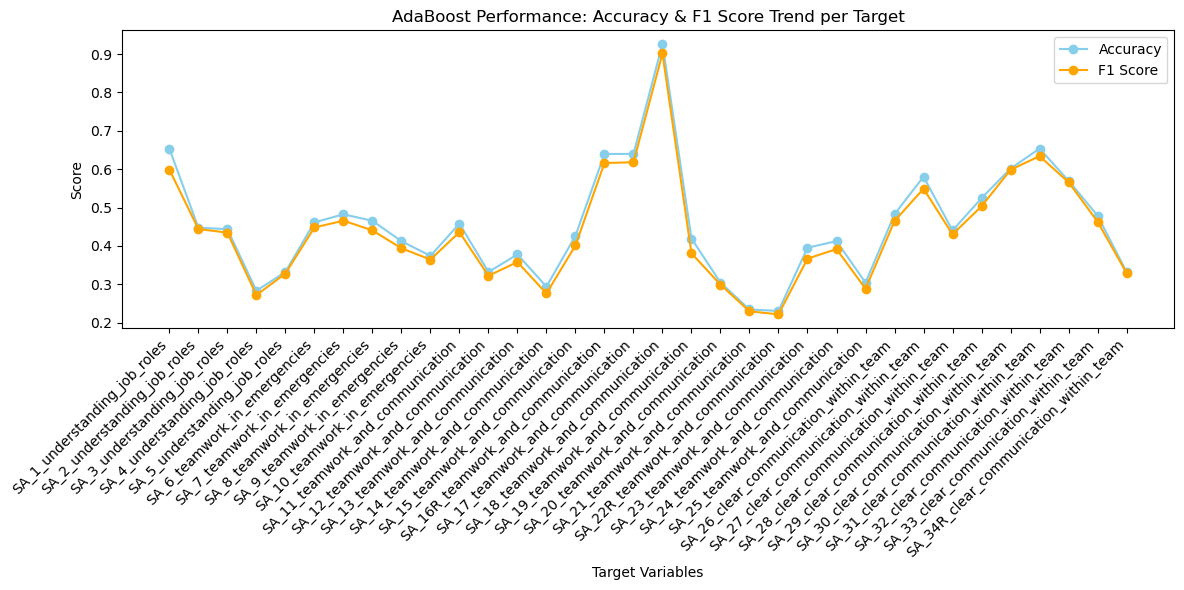

                                    Target  Accuracy  F1 Score
0             SA_1_understanding_job_roles  0.653358  0.598907
1             SA_2_understanding_job_roles  0.447671  0.444049
2             SA_3_understanding_job_roles  0.443618  0.434623
3             SA_4_understanding_job_roles  0.283182  0.271877
4             SA_5_understanding_job_roles  0.332184  0.328122
5             SA_6_teamwork_in_emergencies  0.461404  0.448086
6             SA_7_teamwork_in_emergencies  0.482396  0.465831
7             SA_8_teamwork_in_emergencies  0.465457  0.440523
8             SA_9_teamwork_in_emergencies  0.412462  0.393987
9            SA_10_teamwork_in_emergencies  0.374047  0.364482
10        SA_11_teamwork_and_communication  0.458258  0.435977
11        SA_12_teamwork_and_communication  0.332184  0.322294
12        SA_13_teamwork_and_communication  0.377737  0.357985
13        SA_14_teamwork_and_communication  0.293890  0.276095
14        SA_15_teamwork_and_communication  0.426437  0

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------
# Data Loading and Preparation
# -------------------------------
file_path = r'C:\Users\Χρήστος\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Define target columns
target_columns = [
    "SA_1_understanding_job_roles", "SA_2_understanding_job_roles", "SA_3_understanding_job_roles", 
    "SA_4_understanding_job_roles", "SA_5_understanding_job_roles", "SA_6_teamwork_in_emergencies", 
    "SA_7_teamwork_in_emergencies", "SA_8_teamwork_in_emergencies", "SA_9_teamwork_in_emergencies", 
    "SA_10_teamwork_in_emergencies", "SA_11_teamwork_and_communication", "SA_12_teamwork_and_communication", 
    "SA_13_teamwork_and_communication", "SA_14_teamwork_and_communication", "SA_15_teamwork_and_communication", 
    "SA_16R_teamwork_and_communication", "SA_17_teamwork_and_communication", "SA_18_teamwork_and_communication", 
    "SA_19_teamwork_and_communication", "SA_20_teamwork_and_communication", "SA_21_teamwork_and_communication", 
    "SA_22R_teamwork_and_communication", "SA_23_teamwork_and_communication", "SA_24_teamwork_and_communication", 
    "SA_25_teamwork_and_communication", "SA_26_clear_communication_within_team", "SA_27_clear_communication_within_team", 
    "SA_28_clear_communication_within_team", "SA_29_clear_communication_within_team", "SA_30_clear_communication_within_team", 
    "SA_31_clear_communication_within_team", "SA_32_clear_communication_within_team", "SA_33_clear_communication_within_team", 
    "SA_34R_clear_communication_within_team"
]

# Separate input features and targets
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# ---------------------------------------------------------
# Model Training & Evaluation per Target
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for target in target_columns:
    fold_f1_scores = []
    fold_accuracy_scores = []
    
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = targets.iloc[train_index][target], targets.iloc[test_index][target]
        
        # AdaBoost Classifier with SAMME algorithm
        ab_model = AdaBoostClassifier(n_estimators=200, algorithm='SAMME', random_state=42)
        ab_model.fit(X_train, y_train)
        y_pred = ab_model.predict(X_test)
        
        fold_f1_scores.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
        fold_accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Store average results for this target
    results.append({
        "Target": target,
        "Accuracy": np.mean(fold_accuracy_scores),
        "F1 Score": np.mean(fold_f1_scores)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ---------------------------------------------------------
# Line plot for Accuracy and F1 Score per Target
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(results_df['Target'], results_df['Accuracy'], marker='o', label='Accuracy', color='skyblue')
plt.plot(results_df['Target'], results_df['F1 Score'], marker='o', label='F1 Score', color='orange')

plt.xlabel("Target Variables")
plt.ylabel("Score")
plt.title("AdaBoost Performance: Accuracy & F1 Score Trend per Target")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Print results table
print(results_df)


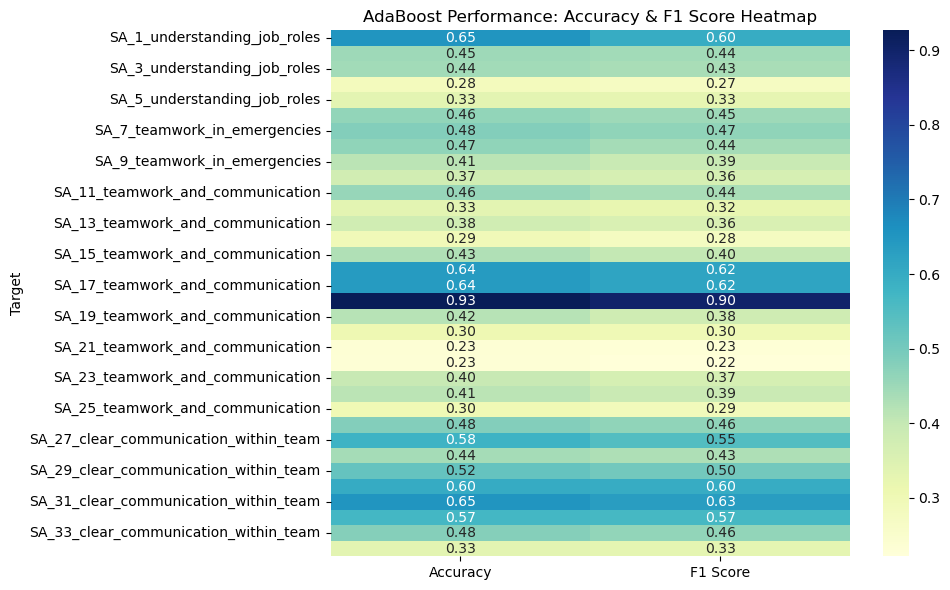

In [6]:
import seaborn as sns
score_matrix = results_df.set_index('Target')[['Accuracy', 'F1 Score']]

plt.figure(figsize=(10, 6))
sns.heatmap(score_matrix, annot=True, cmap="YlGnBu", fmt='.2f', cbar=True)

plt.title("AdaBoost Performance: Accuracy & F1 Score Heatmap")
plt.tight_layout()
plt.show()